# Vanila Autoencoders

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import phate 

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
# Load CSV files into a DataFrame
file1 = '/Users/amittaris/Documents/GitHub/Dimensionality-Reduction-for-Cellular-Differentiation-/DR notebooks/PHATE/datasets/df_facs_decision1.csv'
df_facs_decision1 = pd.read_csv(file1)

file2 ='/Users/amittaris/Documents/GitHub/Dimensionality-Reduction-for-Cellular-Differentiation-/DR notebooks/PHATE/datasets/df_facs_decision2.csv'
df_facs_decision2 = pd.read_csv(file2)


In [3]:
# Forcefully define valid timepoints
genes = df_facs_decision1.drop(df_facs_decision1.columns[[0,1,7,9,10]], axis=1) 


valid_timepoints_for_1 = [2.0, 2.5, 3.0, 3.5]
filtered_df = genes[genes['timepoint'].isin(valid_timepoints_for_1)]

cell_types_0 = filtered_df[filtered_df['cluster_post_replacement'].isin([0])]
cell_types_1 = filtered_df[filtered_df['cluster_post_replacement'].isin([1])]
cell_types_2 = filtered_df[filtered_df['cluster_post_replacement'].isin([2])]
cell_types_3 = filtered_df[filtered_df['cluster_post_replacement'].isin([3])]

data = filtered_df.drop(filtered_df.columns[[ 5, 6, 7]], axis=1)
data = data[:8000]

In [4]:
# 1) Fit PHATE to your matrix `data` (cells × genes):
phate_op = phate.PHATE(n_landmark=8000, n_components=2, knn=10, decay=20)
phate_coords = phate_op.fit(data)    # data is (n_cells, n_genes)
P_t = phate_op._calculate_potential(t="auto") # This is P^t

Running PHATE on 8000 observations and 5 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.26 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.30 seconds.
Calculating optimal t...
  Automatically selected t = 27
Calculated optimal t in 123.04 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 29.41 seconds.


In [5]:
data = P_t
print(data)
print(data.size)

[[ 6.46065167 16.0641722  14.86610605 ... 16.11799921 16.05957689
  16.11804771]
 [16.08617469  5.40210097 16.11809533 ... 15.53883434 15.83479762
  15.938569  ]
 [15.06431812 16.11809524  5.79028104 ... 16.11598612 13.89930372
  16.11600686]
 ...
 [16.11802776 15.45360083 16.11611085 ...  5.07340377  8.62579475
   5.45858856]
 [16.0528973  15.6323639  13.53437799 ...  8.16343657  5.98795687
   8.41700596]
 [16.1180454  15.81644123 16.11517051 ...  5.0604068   8.48135102
   5.35486108]]
64000000


In [6]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = data.shape[1:]
latent_dim = 2
autoencoder = Autoencoder(latent_dim, shape)

In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [8]:
autoencoder.fit(data, data,
                epochs=100,
                shuffle=True,
                validation_data=(data, data))

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 171.1652 - val_loss: 170.0327
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 169.8264 - val_loss: 168.5496
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 168.2223 - val_loss: 167.2041
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 167.1489 - val_loss: 166.0224
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 165.7239 - val_loss: 165.0078
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 164.6051 - val_loss: 164.1493
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 163.5720 - val_loss: 163.4282
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 163.3432 - val_loss: 162.8243
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 162.1973 - val_loss: 162.3178
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 162.1083 - val_loss: 161.8920
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 161.8631 - val_loss: 161.53

In [9]:
encoded_data = autoencoder.encoder(data)
print(encoded_data)



tf.Tensor(
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]], shape=(8000, 2), dtype=float32)


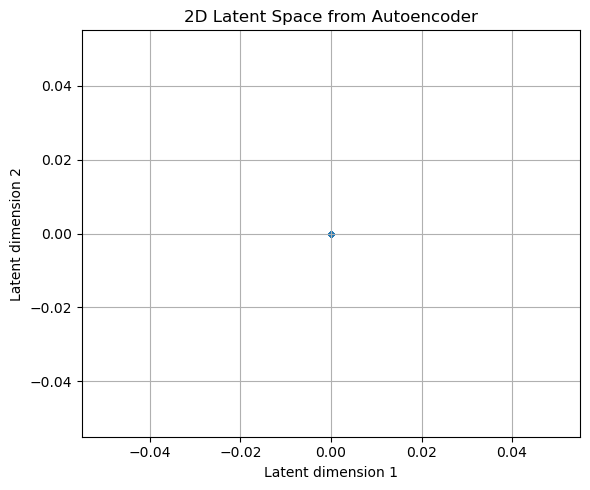

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], s=10, alpha=0.8)
plt.xlabel("Latent dimension 1")
plt.ylabel("Latent dimension 2")
plt.title("2D Latent Space from Autoencoder")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class DeepAutoencoder(Model):
    def __init__(self, latent_dim, input_shape):
        super(DeepAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.input_shape_flat = tf.math.reduce_prod(input_shape)

        # Encoder: Deep stack
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(latent_dim)  # No activation for latent space
        ])

        # Decoder: Mirrors encoder in reverse
        self.decoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(self.input_shape_flat.numpy(), activation='sigmoid'),
            layers.Reshape(input_shape)
        ])

    def call(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed


In [12]:
# Assuming you have: data = (n_samples, 5) or similar
input_shape = data.shape[1:]
latent_dim = 2
autoencoder = DeepAutoencoder(latent_dim, input_shape)

# Compile and train
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data, data, epochs=50, batch_size=32)



Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 159.6860
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 159.1388
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 159.0782
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 159.0744
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 159.1591
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 159.4980
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 158.9545
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 159.3387
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 159.1918
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 158.9219
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 159.0284
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 159.2707
Epoch 13/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 159.0050
Epoch 14/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 158.9703
Epoch 15/50
250/250 ━━━━━━━━━

In [13]:
# Get encoded data
encoded_data = autoencoder.encoder(data).numpy()

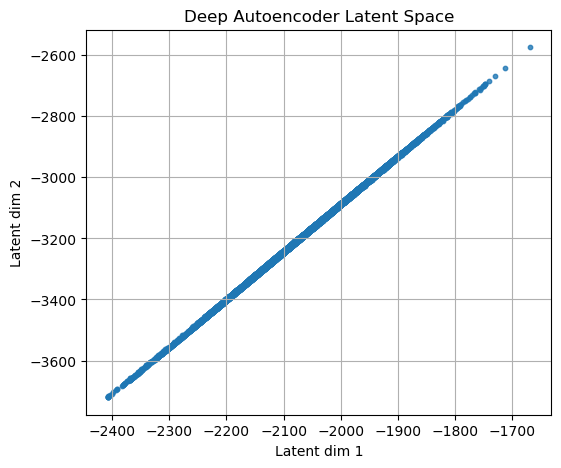

In [14]:
# Plot the 2D latent representation
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], s=10, alpha=0.8)
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.title("Deep Autoencoder Latent Space")
plt.grid(True)
plt.show()

In [15]:
decoded_data = autoencoder.decoder(encoded_data).numpy()
print("First entry of data is", data[:1])
print("First entry of the reconstructed prediction is", decoded_data[:1])

First entry of data is [[ 6.46065167 16.0641722  14.86610605 ... 16.11799921 16.05957689
  16.11804771]]
First entry of the reconstructed prediction is [[1. 1. 1. ... 1. 1. 1.]]
